In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress non-critical warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-10-15 11:24:13.805488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760527454.155802      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760527454.256490      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Image counts per category: {'no': 98, 'yes': 155}


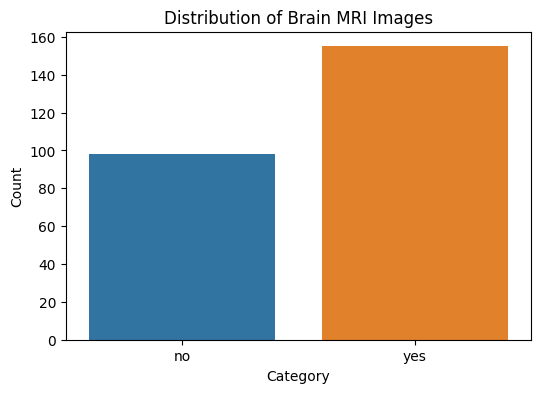

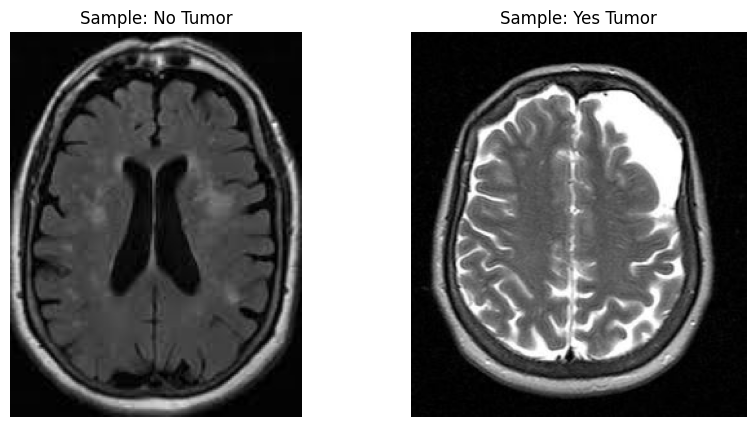

In [5]:
# Define the main data directory
DATA_DIR = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
CATEGORIES = ['no', 'yes']

# Count images in each category
image_counts = {} 
for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    image_counts[category] = len(os.listdir(path))

print("Image counts per category:", image_counts)

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title('Distribution of Brain MRI Images')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Visualize sample images
plt.figure(figsize=(10, 5))
for i, category in enumerate(CATEGORIES):
    path = os.path.join(DATA_DIR, category)
    img_path = os.path.join(path, os.listdir(path)[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(f'Sample: {category.capitalize()} Tumor')
    plt.axis('off')
plt.show()

In [6]:
# Using ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    validation_split=0.2,       # Set aside 20% of data for validation
    rotation_range=15,          # Randomly rotate images
    width_shift_range=0.1,      # Randomly shift images horizontally
    height_shift_range=0.1,     # Randomly shift images vertically
    shear_range=0.1,            # Apply shear transformations
    zoom_range=0.1,             # Randomly zoom into images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'
)

IMG_SIZE = (224, 224) 
BATCH_SIZE = 32

# Create data generators from the directory
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  # Specify this is the training set
)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation', # Specify this is the validation set
    shuffle=False
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [7]:
# --- 1. Build the CNN Model ---
# Initialize the Sequential model (a linear stack of layers).
custom_cnn = Sequential([
    # 1st Conv Layer: Extracts 32 basic features (edges, textures).
    # input_shape is required for the first layer.
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    # Pooling Layer: Downsamples the feature map to reduce computation.
    MaxPooling2D((2, 2)),
    
    # 2nd Conv Layer: Extracts 64 more complex features.
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    
    # 3rd Conv Layer: Extracts 128 high-level features.
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flatten: Converts 2D feature maps into a 1D vector for the Dense layers.
    Flatten(), 
    
    # Dense Layer: Learns complex patterns from the flattened features.
    Dense(512, activation='relu'),
    # Dropout: Prevents overfitting by randomly disabling 50% of neurons.
    Dropout(0.5),
    # Output Layer: A single neuron with a sigmoid function for binary (0 or 1) classification.
    Dense(1, activation='sigmoid')
])

# --- 2. Compile the Model ---
# Configure the model for training with an optimizer, loss function, and evaluation metric.
custom_cnn.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Print a summary of the model architecture.
custom_cnn.summary()


# --- 3. Define Callbacks ---
# Callbacks are functions that monitor and control the training process.
# Stop training if validation loss doesn't improve for 5 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Reduce the learning rate if the training performance plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)


# --- 4. Train the Model ---
# The .fit() function starts training the model on the data.
history_cnn = custom_cnn.fit(
    train_generator,                     # Data generator for training images.
    epochs=25,                           # Number of times to iterate over the entire dataset.
    validation_data=validation_generator, # Data generator for validation.
    callbacks=[early_stop, reduce_lr]    # Apply the callbacks during training.
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5285 - loss: 1.2071 - val_accuracy: 0.7800 - val_loss: 0.6516 - learning_rate: 0.0010
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7057 - loss: 0.6408 - val_accuracy: 0.7000 - val_loss: 0.6166 - learning_rate: 0.0010
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6573 - loss: 0.6466 - val_accuracy: 0.7400 - val_loss: 0.5386 - learning_rate: 0.0010
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7108 - loss: 0.5503 - val_accuracy: 0.7200 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7337 - loss: 0.5379 - val_accuracy: 0.6600 - val_loss: 0.6595 - learning_rate: 0.0010
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6694 - loss: 0.5612 - val_accuracy: 0.7200 - val_loss: 0.5319 - learning_rate: 0.0010
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7386 - loss: 0.5325 - val_accuracy: 0.7200 - val_l

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# --- SETUP THE MODEL ---
weights_path = '/kaggle/input/efficientnetb0b7-keras-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'

# FIX 1: Load weights in two steps to prevent the "Layer count mismatch" error
# 1. Create the model architecture with random weights
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
# 2. Load the saved weights by layer name, skipping any that don't match
base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)

# Freeze the base model initially
base_model.trainable = False 

# Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# --- STAGE 1: FEATURE EXTRACTION ---
# Compile the model for the first stage
efficientnet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

print("--- Starting Stage 1: Feature Extraction ---")
# Train only the top layers
history_effnet = efficientnet_model.fit(
    train_generator,
    epochs=25, # This will likely stop early due to EarlyStopping
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

# --- STAGE 2: FINE-TUNING (FIX 2: This section is now complete) ---
print("\n--- Starting Stage 2: Fine-Tuning ---")

# Unfreeze the top layers of the base model
base_model.trainable = True

# Let's unfreeze the top 30 layers of EfficientNetB0 for this example.
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile the model with a very low learning rate.
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training the model (fine-tuning) 
history_fine_tune = efficientnet_model.fit(
    train_generator,
    epochs=history_effnet.epoch[-1] + 10,  # Train for 10 more epochs
    initial_epoch=history_effnet.epoch[-1],
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

--- Starting Stage 1: Feature Extraction ---
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.5723 - loss: 0.6811 - val_accuracy: 0.6200 - val_loss: 0.6644 - learning_rate: 0.0010
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5617 - loss: 0.7027 - val_accuracy: 0.6200 - val_loss: 0.6642 - learning_rate: 0.0010
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6089 - loss: 0.6748 - val_accuracy: 0.6200 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6053 - loss: 0.6803 - val_accuracy: 0.6200 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6195 - loss: 0.6751
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6178 - loss: 0.6746 - val_accuracy: 0.6200 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6036 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


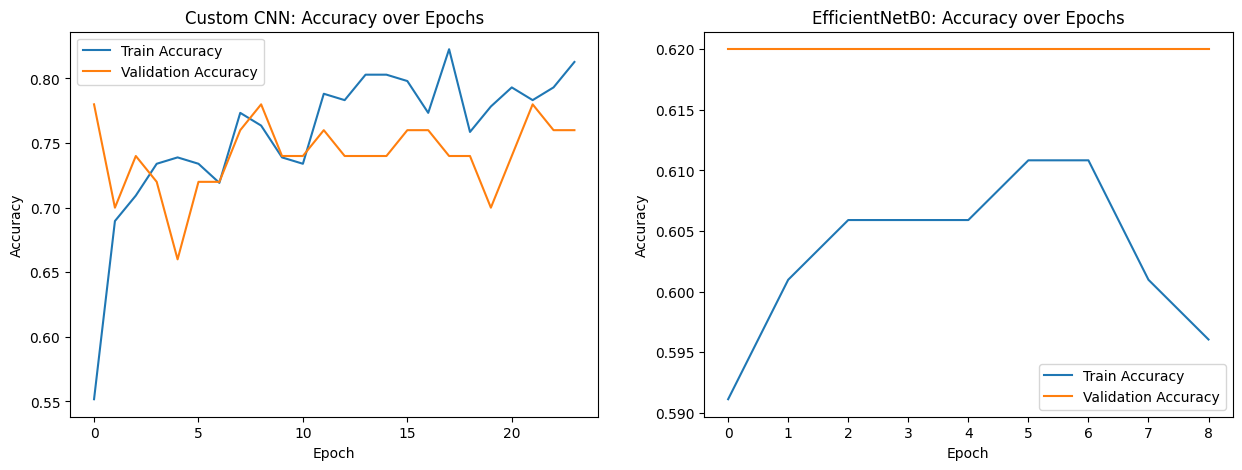

--- Classification Report for Custom CNN ---
              precision    recall  f1-score   support

          no       0.67      0.53      0.59        19
         yes       0.74      0.84      0.79        31

    accuracy                           0.72        50
   macro avg       0.70      0.68      0.69        50
weighted avg       0.71      0.72      0.71        50


--- Classification Report for EfficientNetB0 ---
              precision    recall  f1-score   support

          no       0.00      0.00      0.00        19
         yes       0.62      1.00      0.77        31

    accuracy                           0.62        50
   macro avg       0.31      0.50      0.38        50
weighted avg       0.38      0.62      0.47        50



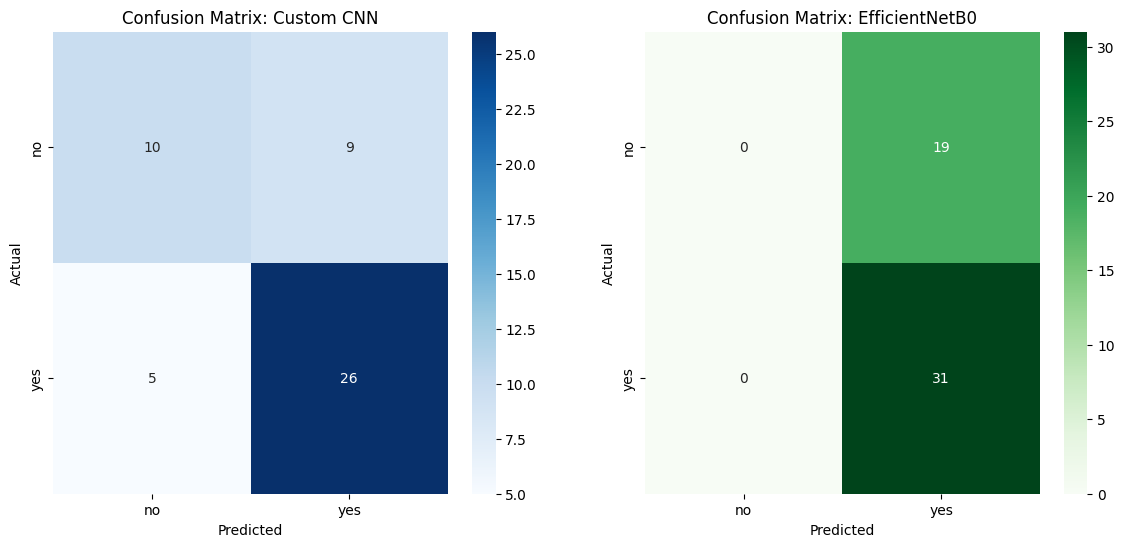

In [9]:
# --- Evaluation ---
# Note: For a final, robust evaluation, a separate test set (not used for validation) is ideal.
# Here, we use the validation set as a proxy for test performance.

# Get predictions from both models
y_true = validation_generator.classes
y_pred_cnn_prob = custom_cnn.predict(validation_generator)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()

y_pred_effnet_prob = efficientnet_model.predict(validation_generator)
y_pred_effnet = (y_pred_effnet_prob > 0.5).astype(int).flatten()

# Get class labels from the generator
class_labels = list(validation_generator.class_indices.keys())

# --- Plotting Training History ---
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# CNN History
ax[0].plot(history_cnn.history['accuracy'], label='Train Accuracy')
ax[0].plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Custom CNN: Accuracy over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend() 

# EfficientNet History
ax[1].plot(history_effnet.history['accuracy'], label='Train Accuracy')
ax[1].plot(history_effnet.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('EfficientNetB0: Accuracy over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

# --- Classification Reports ---
print("--- Classification Report for Custom CNN ---")
print(classification_report(y_true, y_pred_cnn, target_names=class_labels))

print("\n--- Classification Report for EfficientNetB0 ---")
print(classification_report(y_true, y_pred_effnet, target_names=class_labels))

# --- Confusion Matrices ---
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
cm_effnet = confusion_matrix(y_true, y_pred_effnet)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax[0])
ax[0].set_title('Confusion Matrix: Custom CNN')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_effnet, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels, ax=ax[1])
ax[1].set_title('Confusion Matrix: EfficientNetB0')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
plt.show()

In [ ]:
Clinical Implications: 

Prioritize Urgent Cases: Helps radiologists identify and review potentially positive scans faster.

Reduce Diagnostic Errors: Acts as a "second pair of eyes" to increase accuracy and confidence.

Improve Workflow Efficiency: Manages workload by assisting with the large volume of normal scans.